## 5.6 転移学習

- 訓練済みの大規模ネットワークを再利用することで実用的なモデルを安価に訓練することが可能
- グリズリー、黒クマ、テディベアを分類する

- 規模の大きいニューラルネットの学習には膨大な数のデータと、莫大な計算時間が必要
    - 一部の人しか利用できない

#### ネットワークの構成
ニューラルネットワークの層の役割は2つに大別される
- 特徴抽出部
- クラス識別部/回帰部

大規模ネットワークのほとんどは特徴抽出に費やされ、クラス識別を行う部分は
せいぜい2層の全結合層

<img src="images/transferlearning.svg" width="600"/><br/>


特徴抽出部は、入力に近い層では低レベルの特徴(線の傾きなど)をとらえ、
層を経るごとに徐々に高レベルの特徴をとらえるようになる。

最も入力に近い層では、ガボールフィルタと呼ばれる構造が自然に学習される。

<img src="images/Rgabor.png" width="100"/>
<img src="images/Gabor-ocr.png" width="200"/>

https://en.wikipedia.org/wiki/Gabor_filter より

#### 転移学習
- 特徴量抽出部分が十分汎用に訓練されていれば、類似したタスクにも適用できるはず
    - クラス識別部だけを新たに作成
    - 訓練済みの特徴抽出部に接続
    - 少量のデータで訓練

画像についてはImageNetで訓練されたものが入手可能

> **ImageNet**  
> ImageNet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012)
> というコンテストがあり、これに用いられた大規模画像データセット
> 20000種類のオブジェクトが含まれた1千400万枚の画像で構成される。
> ディープラーニングにより飛躍的に精度が向上し、2015年には人間と変わらない精度が出せる
> ようになった。

### 訓練済みモデルの取得

- 訓練済みのモデルはpytorchに含まれているので容易に利用できる。

In [15]:
# hideoutput
import torch
import torchvision

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in /Users/nakada/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/nakada/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nakada/.pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/nakada/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 動作の確認

まずこの訓練済みモデルの動作を確認する。1枚画像を与えて分類してみる。

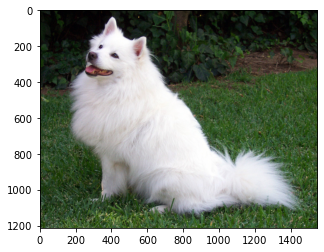

In [16]:
import urllib
from PIL import Image
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", 
                 "dog.jpg")

urllib.request.urlretrieve(url, filename)
image = Image.open("dog.jpg")
plt.imshow(image)

この画像を入力できるように整形してモデルに与える。得られる出力は1000クラスのそれぞれに対する確率。

In [21]:
# hideoutput

from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # ここまでデータの準備

with torch.no_grad():
    output = model(input_batch)   # ここで推論を行っている
probabilities = torch.nn.functional.softmax(output[0], dim=0)

print(probabilities)

tensor([2.2477e-06, 5.7400e-07, 7.9565e-07, 4.7353e-07, 1.4483e-07, 3.1733e-06,
        8.5920e-07, 5.1084e-05, 3.1556e-04, 2.8510e-06, 1.2210e-07, 7.2552e-07,
        4.1613e-07, 1.8176e-07, 1.5905e-07, 4.7587e-07, 1.3131e-06, 8.2814e-06,
        2.1882e-06, 8.3071e-07, 3.3004e-07, 1.3086e-06, 1.4239e-06, 7.6416e-06,
        4.1103e-07, 1.5671e-06, 1.3381e-06, 1.3068e-06, 8.8368e-07, 7.5265e-06,
        7.5759e-07, 9.7183e-07, 1.2716e-06, 1.3984e-07, 2.5436e-07, 7.6369e-07,
        7.4310e-07, 5.0083e-07, 1.4653e-07, 1.3704e-06, 1.6676e-06, 1.8347e-07,
        5.1056e-07, 1.9160e-07, 4.4136e-06, 2.9145e-07, 1.4549e-06, 5.4293e-07,
        2.0363e-07, 7.9109e-07, 2.9179e-06, 1.5745e-06, 2.9114e-06, 3.2598e-06,
        7.5408e-07, 9.5602e-07, 6.9310e-07, 9.6028e-07, 1.4572e-06, 1.4425e-06,
        1.1160e-05, 5.0048e-07, 2.2334e-07, 5.2380e-07, 1.1736e-07, 3.0964e-07,
        1.0006e-06, 9.2338e-07, 8.0743e-07, 2.9008e-08, 9.9102e-07, 3.0449e-06,
        9.7636e-07, 6.3146e-07, 3.0023e-

これでは何もわからないので、クラスのラベルを取得して人間にわかる形に結果を整形する

In [22]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8732960820198059
Pomeranian 0.030270859599113464
white wolf 0.019671134650707245
keeshond 0.0110735222697258
Eskimo dog 0.009204248897731304


### データセットの取得

- 「PyTorchとfastaiではじめるディープラーニング」に従って、データを取得する。
- Bing のサーチAPIを使って検索してURLを得る
- URLからデータを取得

In [ ]:
# hide
#!pip install azure-cognitiveservices-search-imagesearch
#!pip install fastai

from fastai.vision.all import *

# fastai 本の utils より

def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

key = "XXXXXXX" # shoud be filled


def download_data():
    results = search_images_bing(key, 'grizzly bear')    
    bear_types = 'grizzly', 'black', 'teddy'
    path = Path('bears')
    if not path.exists():
        path.mkdir()
        for o in bear_types:
            dest = (path/o)
            dest.mkdir(exist_ok=True)
            results = search_images_bing(key, f'{o} bear')
    #        print(results.attrgot('contentUrl'))
            download_images(dest, urls=results.attrgot('contentUrl'))


In [33]:
# ダウンロード済みファイルのチェック

fns = get_image_files(path)
failed = verify_images(fns)

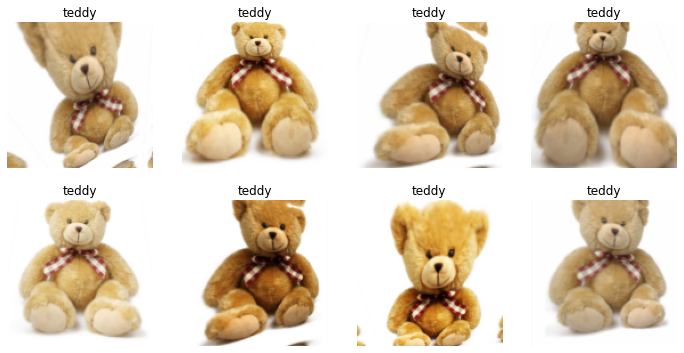

In [36]:
path = Path('bears')

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

bears_a = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears_a.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


In [64]:
# fastai を用いた転移学習   

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)                                                     

l = cnn_learner(dls, resnet18, metrics=error_rate)
l.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.086133,0.941259,0.289855,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.366777,0.425321,0.115942,00:25
1,0.271434,0.278939,0.086957,00:28
2,0.199980,0.254920,0.086957,00:27
3,0.164045,0.178426,0.057971,00:27
4,0.138037,0.108870,0.043478,00:28
5,0.115364,0.085327,0.028986,00:28
6,0.095798,0.066541,0.028986,00:26
7,0.083953,0.056356,0.028986,00:27
8,0.071782,0.051833,0.028986,00:26
9,0.062473,0.052808,0.028986,00:27


GPUのないノート計算機でも、5分足らずで、97%の精度がでている。